In [1]:
!pip uninstall imgaug --yes
!pip install imgaug==0.2.5
!pip install nfts
!pip install stumpy
!pip install statsmodels --upgrade
!pip install dtw-python
!pip install transformers
!pip install backports-datetime-fromisoformat

Found existing installation: imgaug 0.2.5
Uninstalling imgaug-0.2.5:
  Successfully uninstalled imgaug-0.2.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imgaug-0.2.5-py3-none-any.whl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# For sending GET requests from the API
import requests
# For saving access tokens and for file management when creating and adding to the dataset
import os
# For dealing with json responses we receive from the API
import json
# For displaying the data after
import pandas as pd
# For saving the response data in CSV format
import csv
# For parsing the dates received from twitter in readable formats
from datetime import datetime
import dateutil.parser
import unicodedata
#To add wait time between requests
import time
import matplotlib.pyplot as plt
import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

import nfts.dataset
import stumpy

import torch
from tqdm import tqdm

%matplotlib inline
sns.set(color_codes=True)

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

from scipy import stats

import statsmodels.api as sm


import statsmodels.formula.api as smf

INFO:numba.cuda.cudadrv.driver:init
ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


In [3]:
from datetime import date, datetime, time
from backports.datetime_fromisoformat import MonkeyPatch
MonkeyPatch.patch_fromisoformat()

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

In [5]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/NFT/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read Tweets and trades data

### Tweets

In [6]:
df_april = pd.read_csv(DATA_PATH + 'april.csv')
df_may = pd.read_csv(DATA_PATH + 'may.csv')
df_june = pd.read_csv(DATA_PATH + 'june.csv')
df_july = pd.read_csv(DATA_PATH + 'july.csv')
df_august = pd.read_csv(DATA_PATH + 'august.csv')
df_sep = pd.read_csv(DATA_PATH + 'september.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,1,2,4,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
frame = [df_april, df_may, df_june, df_july, df_august, df_sep]
df = pd.concat(frame)
df = df.drop_duplicates()

In [8]:
df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True) 

In [9]:
bins = sorted(df['created_at'].dt.date.unique())
bins = [element for element in bins if type(element) == type(bins[0])]
bins = sorted(bins)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.
  """Entry point for launching an IPython kernel.


### Trades

In [10]:
home_dir = DATA_PATH
DATASET_PATH = os.path.join(home_dir , 'nfts.sqlite')
assert os.path.exists(DATASET_PATH), "Did not find file 'nfts.sqlite' at the given DATASET_PATH."
dataset = nfts.dataset.FromSQLite(DATASET_PATH)

In [11]:
transfers = dataset.load_dataframe('transfers')
transfers['date'] = pd.to_datetime(transfers['timestamp'], unit='s')
transfers['date'] = transfers['date'].apply(lambda x: str(x)[:13])

transfers['transaction_value_eth'] = transfers['transaction_value'] / 1e18

In [12]:
eth_to_usd = {}
with open(DATA_PATH+'ETH-USD.csv', 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file, )
    for row in csv_reader:
        date = str(datetime.fromisoformat(row['Date']).date())
        price = (float(row['Open']) + float(row['Close'])) 
        eth_to_usd[date] = price

dates, exchange_rate = zip(*sorted(eth_to_usd.items()))
temp = pd.DataFrame({
    'dates': dates,
    'exchange_rate': exchange_rate,
})

In [13]:
transfers['transaction_value_usd'] = transfers['date'].map(lambda d: eth_to_usd[d[:10]]) * transfers['transaction_value_eth']

In [14]:
aggregated_sum = transfers.groupby(['date']).sum()
aggregated_mean = transfers.groupby(['date']).mean()

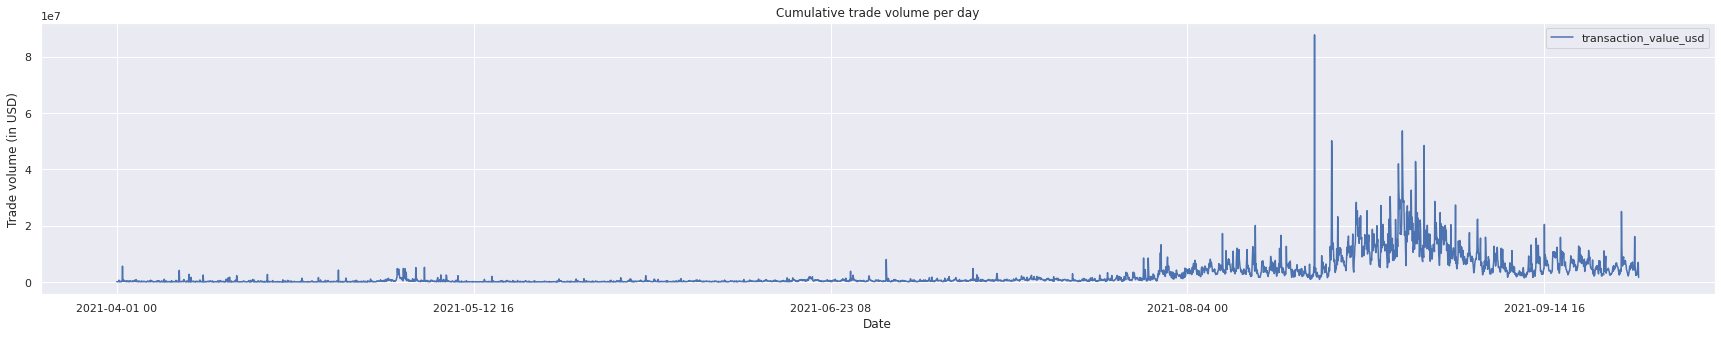

In [25]:
aggregated_sum.plot(y='transaction_value_usd', figsize=(30,5))
plt.title('Cumulative trade volume per day')
plt.xlabel('Date')
plt.ylabel('Trade volume (in USD)')
plt.show()

TypeError: ignored

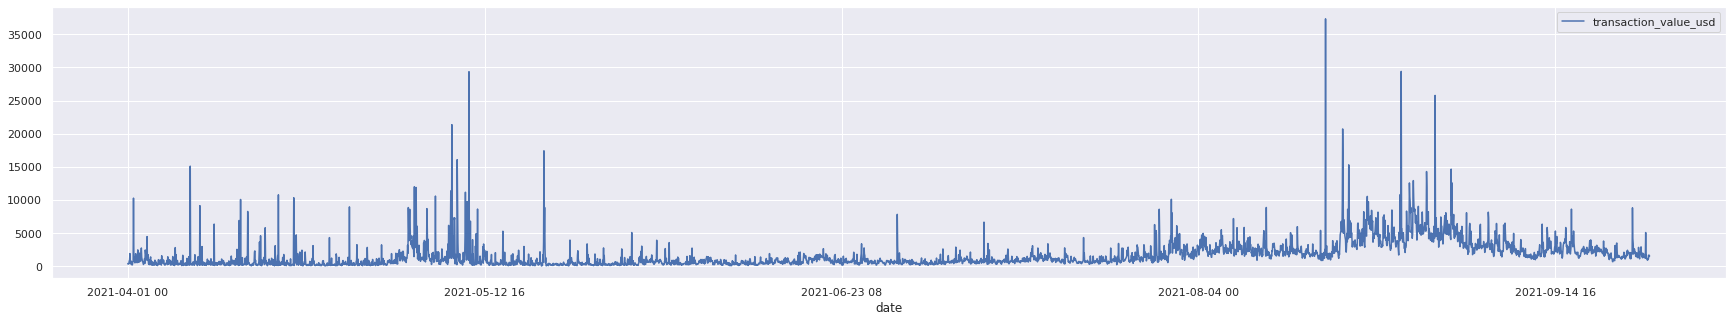

In [28]:
aggregated_mean.plot(y='transaction_value_usd', figsize=(30,5))
plt.title('Cumulative trade volume per day')
plt.xlabel('Date')
plt.ylabel('Trade volume (in USD)')
plt.show()

### Sentiment

In [17]:
sentiment = pd.read_csv(DATA_PATH+'sample_tweet_sentiment.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
sentiment['created_at'] = sentiment['created_at'].apply(lambda x: str(x)[:13])

In [19]:
sentiment = sentiment.groupby('created_at').mean()[:-1][['neg','pos']]

In [20]:
sentiment = sentiment.iloc[:-7]

In [21]:
sentiment_neg = list(sentiment['neg'])
sentiment_pos = list(sentiment['pos'])

sentiment_neg = [(element-np.min(sentiment_neg))/(np.max(sentiment_neg)-np.min(sentiment_neg))for element in sentiment_neg]
sentiment_pos = [(element-np.min(sentiment_pos))/(np.max(sentiment_pos)-np.min(sentiment_pos)) for element in sentiment_pos]

sentiment_score = [pos/(neg + 1) for (neg, pos) in zip(sentiment_neg, sentiment_pos)]
sentiment_score = [(element-np.min(sentiment_score))/(np.max(sentiment_score)-np.min(sentiment_score)) for element in sentiment_score]

In [22]:
sentiment = sentiment.rename_axis('date')
sentiment['score'] = sentiment_score
sentiment = sentiment[['score']]

# Prediction of trade volume

In [ ]:
transfers['datetime'] = pd.to_datetime(transfers['timestamp'], unit='s')
bins = sorted(transfers['datetime'].dt.date.unique())

In [ ]:
df['created_at'] = df['created_at'].apply(lambda x: str(x)[:13])
tweet_count = df.groupby('created_at').count()[['tweet']].iloc[:-1]
tweet_count = tweet_count.rename_axis('date')

transfers['datetime'] = transfers['datetime'].apply(lambda x: str(x)[:13])
trade_count = transfers.groupby('datetime').count()[['event_id']]
trade_count = trade_count.rename_axis('date').rename(columns={'event_id':'trade'})

In [ ]:
bins = sorted(transfers['datetime'].unique())

In [ ]:
temp1 = pd.merge(tweet_count,sentiment,on='date')
temp1.index = temp1.index.map(str) 

aggregated_mean.index = aggregated_mean.index.map(str) 

temp2 = pd.merge(trade_count,aggregated_mean[['transaction_value_usd']],on='date')
temp2.index = temp2.index.map(str) 

In [ ]:
final = pd.merge(temp1, temp2, on='date')

In [ ]:
final = pd.merge(pd.merge(tweet_count,sentiment,on='date'),trade_count,on='date')
#final = pd.merge(trade_count,sentiment,on='date')
final = final[['tweet','score','trade']]
#final['score'] = final['score']*final['trade']

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(final.values)

scaled = pd.DataFrame(scaled)
scaled.index = final.index
scaled.columns = final.columns

final = scaled

In [ ]:
Y = final.iloc[100:]

In [ ]:
final = final.reset_index()

In [ ]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
      for column in df.columns:
        df_n[str(column)+f"lag{n}"] = df_n[column].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n
    
input_dim = 100

In [ ]:
train = generate_time_lags(final, input_dim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


In [ ]:
'''
#Create Window
train = pd.DataFrame(index = final.index)
for i in range(100):
  for column in final.columns:
    train[str(column)+str(i+1)] = 0

train = train.iloc[99:]

for idx, row in final.iterrows():
    for column in final.columns:
        for i in range(100):
            try:
                train.loc[idx+i, str(column)+str(i+1)] = final.iloc[idx][str(column)]
            except:
                pass
'''

'\n#Create Window\ntrain = pd.DataFrame(index = final.index)\nfor i in range(100):\n  for column in final.columns:\n    train[str(column)+str(i+1)] = 0\n\ntrain = train.iloc[99:]\n\nfor idx, row in final.iterrows():\n    for column in final.columns:\n        for i in range(100):\n            try:\n                train.loc[idx+i, str(column)+str(i+1)] = final.iloc[idx][str(column)]\n            except:\n                pass\n'

In [ ]:
train = train[[ x for x in train.columns if "date" not in x]]

In [ ]:
train.index = Y.index

In [ ]:
train_column = list(train.columns)
train_column.remove('trade')
train_column.remove('tweet')
train_column.remove('score')

X_train = train[train_column].iloc[:int(len(train)/2)]
y_train = train["trade"].iloc[:int(len(train)/2)]

X_test = train[train_column].iloc[int(len(train)/2):]
y_test = train["trade"].iloc[int(len(train)/2):]

In [ ]:
X_train = X_train[[ x for x in X_train.columns if "trade1" not in x]]
X_test = X_test[[ x for x in X_train.columns if "trade1" not in x]]

In [ ]:
regr = MLPRegressor(random_state=1, max_iter=10)
regr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPRegressor(max_iter=10, random_state=1)

In [ ]:
RandomForestregressor = RandomForestRegressor(max_depth=20, random_state=0)
RandomForestregressor.fit(X_train, y_train)

In [ ]:
BayesianRidgeregressor = BayesianRidge()
Linearregressor = LinearRegression()
XGBregressor = XGBRegressor()
GradientBoostingregressor = GradientBoostingRegressor()
SVRegressior = SVR()

BayesianRidgeregressor.fit(X_train, y_train)
Linearregressor.fit(X_train, y_train)
XGBregressor.fit(X_train, y_train)
GradientBoostingregressor.fit(X_train, y_train)
SVRegressior.fit(X_train, y_train)

[16:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


SVR()

In [ ]:
print(mean_squared_error(regr.predict(X_train), list(y_train)))
print(mean_squared_error(SVRegressior.predict(X_train), list(y_train)))
print(mean_squared_error(BayesianRidgeregressor.predict(X_train), list(y_train)))
print(mean_squared_error(Linearregressor.predict(X_train), list(y_train)))
#print(mean_squared_error(RandomForestregressor.predict(X_train), list(y_train)))
print(mean_squared_error(XGBregressor.predict(X_train), list(y_train)))
print(mean_squared_error(GradientBoostingregressor.predict(X_train), list(y_train)))

0.0028375208561896453
0.003258804527294
0.0003545411223302257
0.00032825990735438766
0.00013787749071013142
0.0001435270006417755


In [ ]:
print(mean_squared_error(regr.predict(X_test), list(y_test)))
print(mean_squared_error(SVRegressior.predict(X_test), list(y_test)))
print(mean_squared_error(BayesianRidgeregressor.predict(X_test), list(y_test)))
print(mean_squared_error(Linearregressor.predict(X_test), list(y_test)))
#print(mean_squared_error(RandomForestregressor.predict(X_test), list(y_test)))
print(mean_squared_error(XGBregressor.predict(X_test), list(y_test)))
print(mean_squared_error(GradientBoostingregressor.predict(X_test), list(y_test)))

0.02536112604397867
0.040072213014891715
0.0036715927694602585
0.0034816940005921357
0.01986001822306095
0.01787216411704514


In [ ]:
mean_squared_error(list(train["tradelag100"].iloc[int(len(train)/2):][1:]), list(train["tradelag100"].iloc[int(len(train)/2):].shift(periods=1)[1:]))

0.00390026334742557

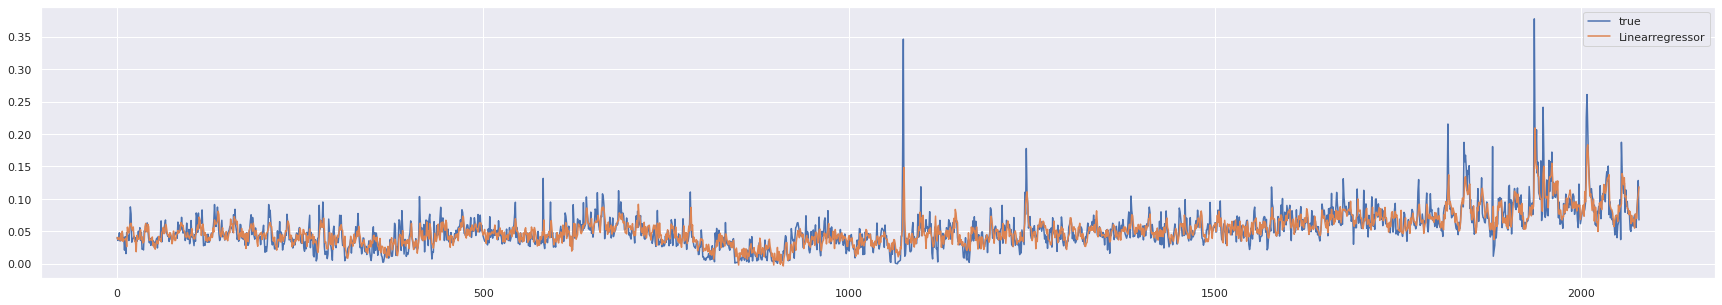

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(list(y_train))
plt.plot(Linearregressor.predict(X_train))
plt.legend(['true', 'Linearregressor'])
plt.show()

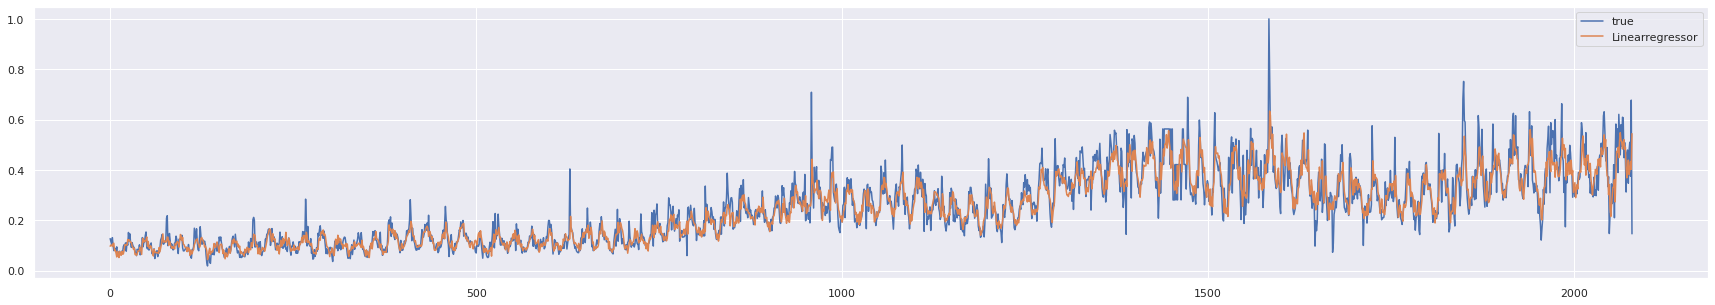

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(list(y_test))
plt.plot(Linearregressor.predict(X_test))
plt.legend(['true', 'Linearregressor'])
plt.show()

In [ ]:
X_train.head(1)

,tweetlag1,scorelag1,tradelag1,tweetlag2,scorelag2,tradelag2,tweetlag3,scorelag3,tradelag3,tweetlag4,...,tradelag97,tweetlag98,scorelag98,tradelag98,tweetlag99,scorelag99,tradelag99,tweetlag100,scorelag100,tradelag100
date,,,,,,,,,,,,,,,,,,,,,
2021-04-05 04,0.038328,0.39382,0.041573,0.035994,0.509602,0.033963,0.039573,0.465096,0.044391,0.041647,...,0.028044,0.023183,0.314941,0.031849,0.021887,0.398222,0.038895,0.03226,0.402217,0.04566


# Prediction of Average NFT Price

In [ ]:
temp1 = pd.merge(tweet_count,sentiment,on='date')
temp1.index = temp1.index.map(str) 

aggregated_mean.index = aggregated_mean.index.map(str) 

temp2 = pd.merge(trade_count,aggregated_mean[['transaction_value_usd']],on='date')
temp2.index = temp2.index.map(str) 

In [ ]:
final = pd.merge(temp1, temp2, on='date')

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(final.values)

scaled = pd.DataFrame(scaled)
scaled.index = final.index
scaled.columns = final.columns

final = scaled

In [ ]:
final = final[['transaction_value_usd','score']]

In [ ]:
Y = final.iloc[100:]

final = final.reset_index()

In [ ]:
train = generate_time_lags(final, input_dim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


In [ ]:
#Delete Date Column
train = train[[ x for x in train.columns if "date" not in x]]

In [ ]:
train.index = Y.index

In [ ]:
train_column = list(train.columns)

train_column.remove('transaction_value_usd')

X_train = train[train_column].iloc[:int(len(train)/2)]
y_train = train["transaction_value_usd"].iloc[:int(len(train)/2)]

X_test = train[train_column].iloc[int(len(train)/2):]
y_test = train["transaction_value_usd"].iloc[int(len(train)/2):]

In [ ]:
BayesianRidgeregressor = BayesianRidge()
Linearregressor = LinearRegression()
XGBregressor = XGBRegressor()
GradientBoostingregressor = GradientBoostingRegressor()

BayesianRidgeregressor.fit(X_train, y_train)
Linearregressor.fit(X_train, y_train)
XGBregressor.fit(X_train, y_train)
GradientBoostingregressor.fit(X_train, y_train)

[16:29:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GradientBoostingRegressor()

In [ ]:
print(mean_squared_error(BayesianRidgeregressor.predict(train[train_column].iloc[:int(len(train)/2)]), list(train["transaction_value_usd"].iloc[:int(len(train)/2)])))
print(mean_squared_error(Linearregressor.predict(train[train_column].iloc[:int(len(train)/2)]), list(train["transaction_value_usd"].iloc[:int(len(train)/2)])))
#print(mean_squared_error(RandomForestregressor.predict(train[train_column].iloc[:int(len(train)/2)]), list(train["transaction_value_usd"].iloc[:int(len(train)/2)])))
print(mean_squared_error(XGBregressor.predict(train[train_column].iloc[:int(len(train)/2)]), list(train["transaction_value_usd"].iloc[:int(len(train)/2)])))
print(mean_squared_error(GradientBoostingregressor.predict(train[train_column].iloc[:int(len(train)/2)]), list(train["transaction_value_usd"].iloc[:int(len(train)/2)])))

0.0013504240874344718
0.0012636662295834398
0.0003267460010549871
0.00030032499706132573


In [ ]:
print(mean_squared_error(BayesianRidgeregressor.predict(train[train_column].iloc[int(len(train)/2):]), list(train["transaction_value_usd"].iloc[int(len(train)/2):])))
print(mean_squared_error(Linearregressor.predict(train[train_column].iloc[int(len(train)/2):]), list(train["transaction_value_usd"].iloc[int(len(train)/2):])))
#print(mean_squared_error(RandomForestregressor.predict(train[train_column].iloc[int(len(train)/2):]), list(train["transaction_value_usd"].iloc[int(len(train)/2):])))
print(mean_squared_error(XGBregressor.predict(train[train_column].iloc[int(len(train)/2):]), list(train["transaction_value_usd"].iloc[int(len(train)/2):])))
print(mean_squared_error(GradientBoostingregressor.predict(train[train_column].iloc[int(len(train)/2):]), list(train["transaction_value_usd"].iloc[int(len(train)/2):])))

0.0021704170323616385
0.001974863149146976
0.0020165610746473873
0.00205596671666187


In [ ]:
mean_squared_error(list(train["transaction_value_usdlag100"].iloc[int(len(train)/2):])[1:], list(train["transaction_value_usdlag100"].iloc[int(len(train)/2):].shift(periods=1))[1:])

0.0027908092022489676

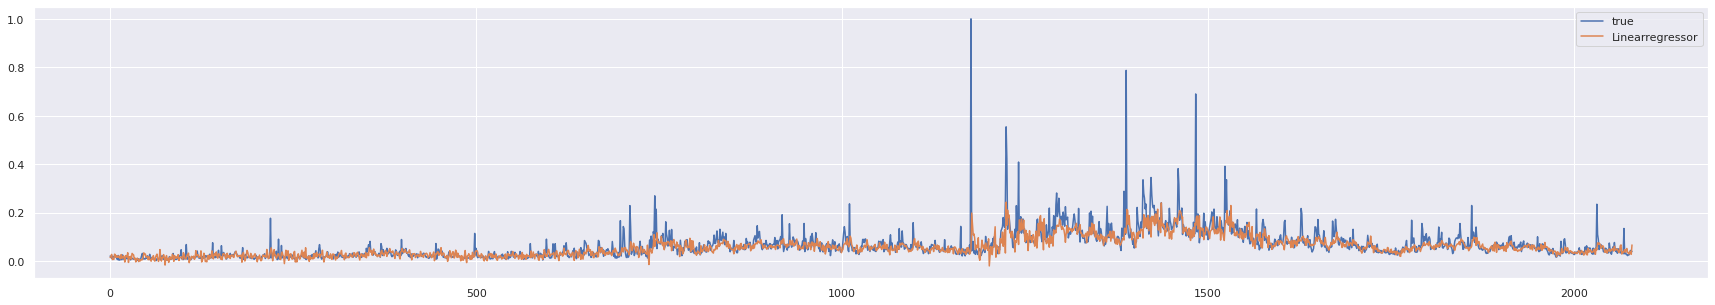

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(list(y_test))
plt.plot(Linearregressor.predict(X_test))
plt.legend(['true', 'Linearregressor'])
plt.show()

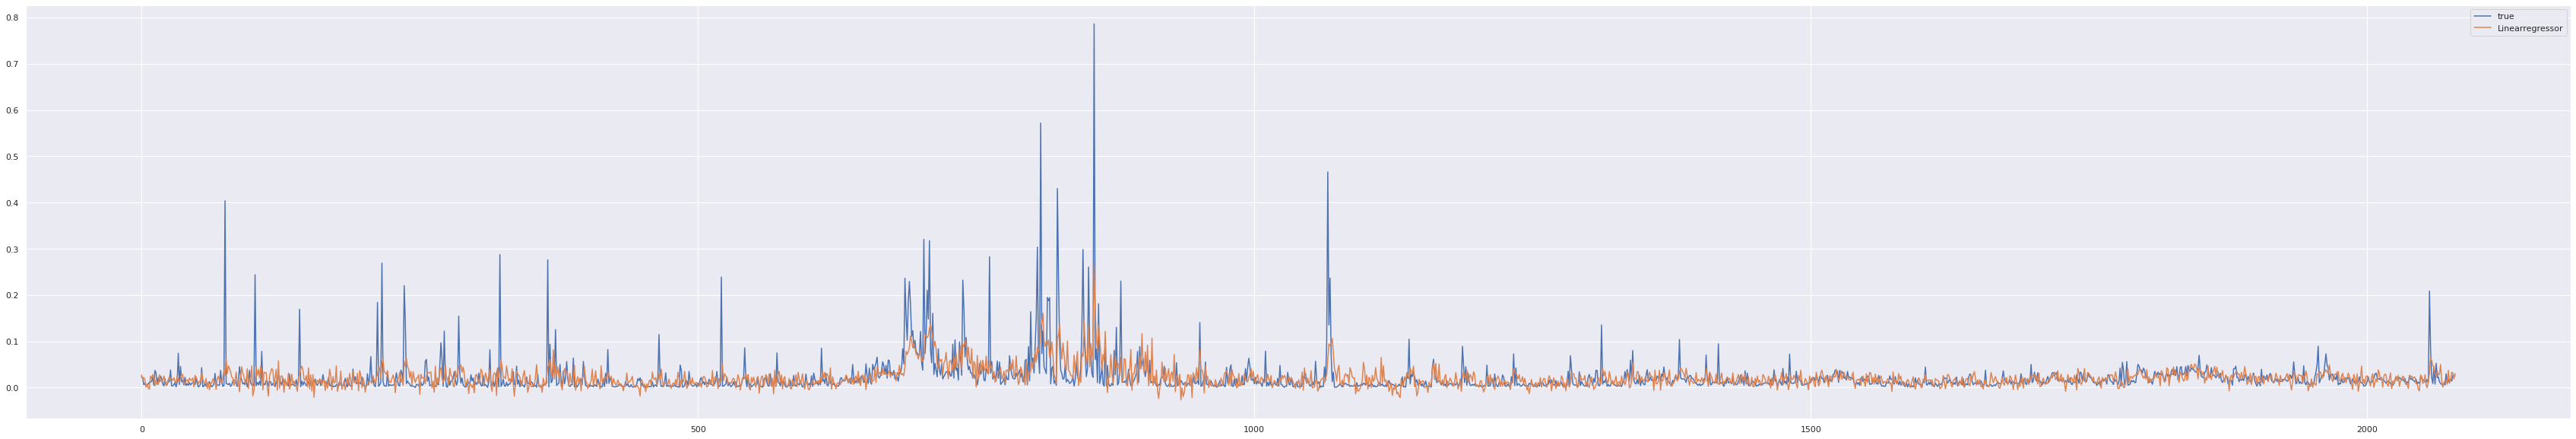

In [ ]:
plt.figure(figsize=(60,10))
plt.plot(list(y_train))
plt.plot(Linearregressor.predict(X_train))
plt.legend(['true', 'Linearregressor'])
plt.show()

## LSTM

In [ ]:
final = pd.merge(temp1, temp2, on='date')

final

,tweet,score,trade,transaction_value_usd
date,,,,
2021-04-01 00,1905,0.402217,329,369.963975
2021-04-01 01,1705,0.398222,281,278.714642
2021-04-01 02,1730,0.314941,231,299.630962
2021-04-01 03,1708,0.433093,204,400.321427
2021-04-01 04,1911,0.474644,158,753.605724
...,...,...,...,...
2021-09-25 12,14274,0.415182,3386,990.225318
2021-09-25 13,14777,0.440973,3626,1212.343343
2021-09-25 14,17654,0.446107,2668,1664.032763


In [ ]:
train_column = list(train.columns)
train_column.remove('transaction_value_usd')

X_train = train[train_column].iloc[:int(len(train)/2)]
y_train = train["transaction_value_usd"].iloc[:int(len(train)/2)]

X_test = train[train_column].iloc[int(len(train)/2):]
y_test = train["transaction_value_usd"].iloc[int(len(train)/2):]

In [ ]:
import torch
import torch.nn as nn


class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
torch.from_numpy(X_train.values).float().to('cpu')

tensor([[0.4577, 0.0104, 0.3938,  ..., 0.3982, 0.0098, 0.4022],
        [0.0182, 0.0237, 0.4577,  ..., 0.3149, 0.0074, 0.3982],
        [0.3053, 0.0199, 0.0182,  ..., 0.4331, 0.0079, 0.3149],
        ...,
        [0.6620, 0.0143, 0.4213,  ..., 0.3707, 0.0198, 0.2128],
        [0.4227, 0.0267, 0.6620,  ..., 0.4343, 0.0114, 0.3707],
        [0.4354, 0.0259, 0.4227,  ..., 0.3937, 0.0110, 0.4343]])

In [ ]:
rnn = LSTM()

if torch.cuda.is_available():
    rnn = rnn.cuda()

optimizer = optimizer
loss_func = loss_function

for step in range(100):
    for tx, ty in zip(torch.from_numpy(X_train.values).float().to('cpu'), torch.from_numpy(y_train.values).float().to('cpu')):
        
        if torch.cuda.is_available():
            tx = tx.cuda()
            ty = ty.cuda()       
        
        output = rnn(torch.unsqueeze(tx, dim=2))
        loss = loss_func(torch.squeeze(output), ty)
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # back propagation, compute gradients
        optimizer.step()
    print(step, loss.cpu())
    if step % 10:
        torch.save(rnn, 'rnn.pkl')
torch.save(rnn, 'rnn.pkl')

IndexError: ignored